In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Vision Transformer so far</span>

We have tested ViT training with weak supervision in the notebook `nb_2_vision_transformer_tests.ipynb`. We also implemented a routine to pre-train ViTs in the TinyImagenet dataset (`nb_3_ViT_pretraining.ipynb`). Finally, we implemented a custom dataset in `src/commons/dataset.py` to tackle this weak supervision training.

Now, the goal is to:
1. Load data using the custom dataset
2. Load pretrained models
3. Fine tune them in the MVTec data
4. Inspect results
   1. Accuracy of "is anomaly" binary prediction
   2. Visualize segmentation masks extracted from attention
5. Use different patch sizes to obtain masks at different resolutions, and combine the results
6. Compare the ensemble results with the previous results


## Initialize data

Desired image transformations should be included in the `transforms.Compose` wrapper.

*Note:* what sort of data augmentation may be useful for our task?

*Note 2:* should we implement transforms only at the dataloader level?

In [2]:
# Load dataset
cat = "capsule"
transf = transforms.Compose([
    transforms.Resize((64, 64)), # Resize to match TinyImagenet resolution
    transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
])
data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat, transforms=transf)

# Split data into train/test/val
train_data, test_data, val_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

In [3]:
# Define DataLoaders for batching input
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

In [22]:
for sample in data:
    if ('011' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["inputs"], sample["ground_truth"], sample['class_and_id']
    elif ('010' in sample['class_and_id']) and ('faulty_imprint' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["inputs"], sample["ground_truth"], sample['class_and_id']

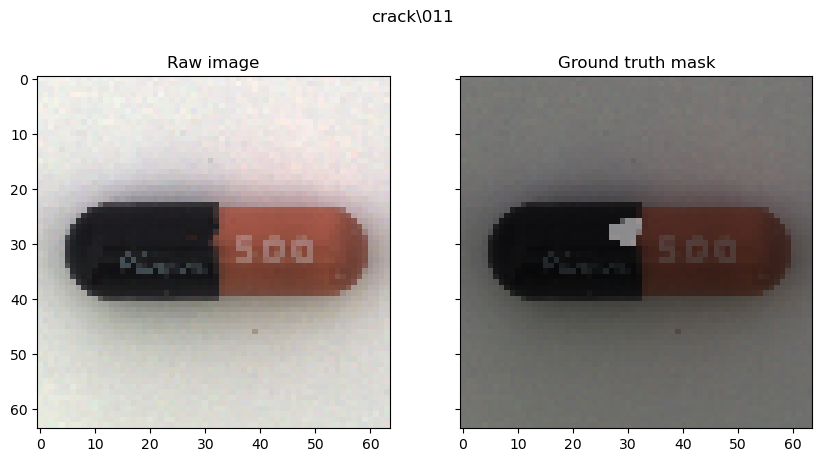

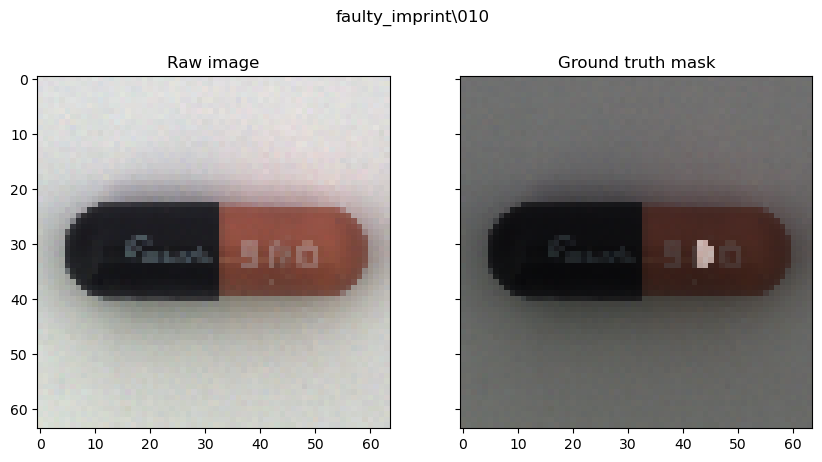

In [23]:
show_img_and_mask(img1, mask1, ex_name1)
show_img_and_mask(img2, mask2, ex_name2)

## Load pre-trained model

*Note: * what is the best way to handle hyper-parameter definition / storage?

In [16]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 4
HIDDEN_DIM = 256

# Load pretrained model
pretrained_model = vit.SimpleViT(
    image_size = 64,
    patch_size = PATCH_SIZE,
    num_classes = 200,
    dim = HIDDEN_DIM,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_pretrained_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
pretrained_model.load_state_dict(loaded["model_state_dict"])

# Define new output layer
linear_head = nn.Sequential(nn.LayerNorm(HIDDEN_DIM), nn.Linear(HIDDEN_DIM, 1))

# Load pretrained weights, discard pretrained output layer and replace with custom
model = nn.Sequential(*(list(pretrained_model.children())[:-1]), linear_head)

Loaded model, epoch:16, loss:3.3293343412990386


Sequential(
  (0): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (1): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
      (1): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (atten

## Fine tuning routine

In [17]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = nn.functional.softmax(logits, dim=1)
            pred_cats = preds.argmax(dim=1)
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets)
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            inputs, targets = batch["inputs"], batch["labels"]
            inputs, targets = inputs.to(device), targets.to(device)
    
            print(f"Batch - Input: {inputs.shape, type(inputs), inputs.dtype} Target: {targets.shape, type(targets), targets.dtype}")

            model.zero_grad() # initialize gradients to zero
            logits = model(inputs) # forward pass

            print(f"Logits - {logits.shape}, {type(logits)}, {logits.dtype}")

            loss = loss_fn(logits, targets) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = nn.functional.softmax(logits, dim=1)
                pred_cats = preds.argmax(dim=1)
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [18]:
# Define training parameters
LEARNING_RATE = 5e-5
NUM_EPOCHS = 50
print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  32
CHECKPOINT PATH:  ..\results
Total parameters: 1.59e+06
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   32363 KB |   45382 KB |  181329 KB |  148966 KB |
|       from large pool |   15872 KB |   22016 KB |   88064 KB |   72192 KB |
|       from small pool |   16491 KB |   23366 KB |   93265 KB |   76774 KB |
|---------------------------------------------------------------------------|
| Active memory         |   32363 KB |   45382 KB |  1813

In [19]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/50


  0%|          | 0/9 [00:00<?, ?it/s]

Batch - Input: (torch.Size([32, 3, 64, 64]), <class 'torch.Tensor'>, torch.float32) Target: (torch.Size([32, 1]), <class 'torch.Tensor'>, torch.int8)


  0%|          | 0/9 [00:06<?, ?it/s]


EinopsError:  Error while processing rearrange-reduction pattern "b n (h d) -> b h n d".
 Input tensor shape: torch.Size([32, 16, 16, 512]). Additional info: {'h': 8}.
 Expected 3 dimensions, got 4